In [ ]:
import scipy.io as scipy
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn import preprocessing
import tensorflow as tf
import os
import librosa.display

In [ ]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = '/content/drive/MyDrive/Inertial/a'
b = '_s'
c = '_t'
d = '_inertial.mat'

file_list = []
for i in range(10,20):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(1,2):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(20,28):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(2,10):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
file_list.remove('/content/drive/MyDrive/Inertial/a8_s1_t4_inertial.mat')
file_list.remove('/content/drive/MyDrive/Inertial/a23_s6_t4_inertial.mat')
file_list.remove('/content/drive/MyDrive/Inertial/a27_s8_t4_inertial.mat')

In [ ]:
def melspectrum(data):
        data_x = data[:,0]
        data_y = data[:,1]
        data_z = data[:,2]
        data_x = data_x.reshape(-1)
        data_y = data_y.reshape(-1)
        data_z = data_z.reshape(-1)
        data_xx = np.interp(np.linspace(0, data_x.size, 10000), np.arange(data_x.size), data_x)
        Sx = librosa.feature.melspectrogram(data_xx, sr=100)
        Sx_dB = librosa.power_to_db(Sx, ref=np.max)
        data_yy = np.interp(np.linspace(0, data_y.size, 10000), np.arange(data_y.size), data_y)
        Sy = librosa.feature.melspectrogram(data_yy, sr=100)
        Sy_dB = librosa.power_to_db(Sy, ref=np.max)
        data_zz = np.interp(np.linspace(0, data_z.size, 10000), np.arange(data_z.size), data_z)
        Sz = librosa.feature.melspectrogram(data_zz, sr=100)
        Sz_dB = librosa.power_to_db(Sz, ref=np.max)
        S_db = np.dstack((Sx_dB, Sy_dB, Sz_dB))
        S_norm = S_db-S_db.min()
        S_norm /= S_norm.max()
        return S_norm

In [ ]:
def load_data(data_directory):
    file_names = file_list
    train_labels = []
    train_datas = []
    test_labels = []
    test_datas = []
    train_split = [1,3,5,7]
    for d in file_names:
        label = d[-21:-19]
        if 'a' in label[0]:
            label = label[-1]
        label = int(label)
        if label == 27:
          label = 0
        if int(d[-17:-16]) in train_split:
            train_labels.append(label)
            data = scipy.loadmat(d)
            data = data['d_iner'][:,:3]
            S_norm = melspectrum(data)
            train_datas.append(S_norm)
        else:
            test_labels.append(label)
            data = scipy.loadmat(d)
            data = data['d_iner'][:,:3]
            S_norm = melspectrum(data)
            test_datas.append(S_norm) 
    train_labels = np.array(train_labels)
    train_datas = np.array(train_datas)
    test_labels = np.array(test_labels)
    test_datas = np.array(test_datas)
    return train_labels,train_datas,test_labels,test_datas

**skeleton data preprocessing**

In [ ]:
def images_creater(file):
    data = scipy.loadmat(file)
    data = data['d_skel']
    x_images = data[0,0,:]
    y_images = data[0,0,:]
    z_images = data[0,0,:]
    for i in range(20):
        for j in range(3):
            if j == 0:
                x_images = np.vstack((x_images,data[i,j,:]))
            elif j == 1:
                y_images = np.vstack((y_images,data[i,j,:]))
            else:
                z_images = np.vstack((z_images,data[i,j,:]))
    x_images=x_images[1:,:]
    y_images=y_images[1:,:]
    z_images=z_images[1:,:]
    v_x = np.lib.stride_tricks.sliding_window_view(x_images,(20,40))
    v_y = np.lib.stride_tricks.sliding_window_view(y_images,(20,40))
    v_z = np.lib.stride_tricks.sliding_window_view(z_images,(20,40))
    v_squeeze = v_x.squeeze()
    v_x = np.expand_dims(v_squeeze,axis=-1)
    v_squeeze = v_y.squeeze()
    v_y = np.expand_dims(v_squeeze,axis=-1)
    v_squeeze = v_z.squeeze()
    v_z = np.expand_dims(v_squeeze,axis=-1)
    v_expand = np.concatenate((v_x,v_y,v_z), axis=3)

    label = file[-21:-19]
    if 'a' in label[0]:
        label = label[-1]
    label=int(label)
    if label == 27:
        label = 0
    labels = np.zeros(v_expand.shape[0],dtype = 'int32')
    for i in range(v_expand.shape[0]):
        labels[i] = label
    return v_expand,labels

In [ ]:
a = '/content/drive/MyDrive/Skeleton/a'
b = '_s'
c = '_t'
d = '_skeleton.mat'
file_list_skeleton = []
for i in range(10,20):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
for i in range(1,2):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
for i in range(20,28):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
for i in range(2,10):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
file_list_skeleton.remove('/content/drive/MyDrive/Skeleton/a23_s6_t4_skeleton.mat')
file_list_skeleton.remove('/content/drive/MyDrive/Skeleton/a27_s8_t4_skeleton.mat')
file_list_skeleton.remove('/content/drive/MyDrive/Skeleton/a8_s1_t4_skeleton.mat')

In [ ]:
def load_skeleton_data(data_directory):
    file_names = file_list_skeleton
    path = '/content/drive/MyDrive/Skeleton/a1_s1_t1_skeleton.mat'
    images,labels = images_creater(path)
    train_datas = images
    train_labels = labels
    test_datas = images
    test_labels = labels
    train_split = [1,3,5,7]
    for d in file_names:
        images,labels = images_creater(d)
        if int(d[-17:-16]) in train_split:
            train_labels = np.append(train_labels,labels,axis = 0)
            train_datas = np.append(train_datas,images,axis = 0)
        else:
            test_labels = np.append(test_labels,labels,axis = 0)
            test_datas = np.append(test_datas,images,axis = 0)
    train_datas = train_datas[29:,:,:,:]    
    test_datas = test_datas[29:,:,:,:]
    test_labels = test_labels[29:]
    train_labels = train_labels[29:]
    return train_labels,train_datas,test_labels,test_datas

In [ ]:
interial_directory = '/content/drive/MyDrive/Inertial'
train_y1,train_x1,test_y1,test_x1 = load_data(interial_directory)

In [ ]:
count = 0
l1 = [i for i in range(10,20)]
l2 = [i for i in range(20,27)]
l3 = [i for i in range(2,10)]
l = l1 + [1] + l2 + [0] + l3
for j in l:
  count = 0
  for i in train_y1:
    if i == j:
      count += 1
  print(count)

In [ ]:
count1 = 0
l1 = [i for i in range(10,20)]
l2 = [i for i in range(20,27)]
l3 = [i for i in range(2,10)]
l = l1 + [1] + l2 + [0] + l3
print(l)
for j in l:
  count1 = 0
  for i in train_yy:
    if i == j:
      count1 += 1
  print(count1)

In [ ]:
skeleton_directory = '/content/drive/MyDrive/Skeleton'
train_y2,train_x2,test_y2,test_x2 = load_skeleton_data(skeleton_directory)

In [ ]:
n = 15
train_x21 = train_x2[::n, ...]
train_y21 = train_y2[::n, ...]
test_x21 = test_x2[::n, ...]
test_y21 = test_y2[::n, ...]
print(train_y21.shape)
print(train_x21.shape)
print(test_y21.shape)
print(test_x21.shape)

(825,)
(825, 20, 40, 3)
(821,)
(821, 20, 40, 3)


In [ ]:
train_xnew1 = train_x21[:16]
train_ynew1 = train_y21[:16]
train_xx = np.concatenate((train_x21[:16], train_x21[37:53]))
train_yy = np.concatenate((train_y21[:16], train_y21[37:53]))
train_xx = np.concatenate((train_xx, train_x21[75:91]))
train_yy = np.concatenate((train_yy, train_y21[75:91]))
train_xx = np.concatenate((train_xx, train_x21[118:134]))
train_yy = np.concatenate((train_yy, train_y21[118:134]))
train_xx = np.concatenate((train_xx, train_x21[151:167]))
train_yy = np.concatenate((train_yy, train_y21[151:167]))
train_xx = np.concatenate((train_xx, train_x21[191:207]))
train_yy = np.concatenate((train_yy, train_y21[191:207]))
train_xx = np.concatenate((train_xx, train_x21[219:235]))
train_yy = np.concatenate((train_yy, train_y21[219:235]))
train_xx = np.concatenate((train_xx, train_x21[239:255]))
train_yy = np.concatenate((train_yy, train_y21[239:255]))
train_xx = np.concatenate((train_xx, train_x21[271:287]))
train_yy = np.concatenate((train_yy, train_y21[271:287]))
train_xx = np.concatenate((train_xx, train_x21[293:309]))
train_yy = np.concatenate((train_yy, train_y21[293:309]))
train_xx = np.concatenate((train_xx, train_x21[321:337]))
train_yy = np.concatenate((train_yy, train_y21[321:337]))
train_xx = np.concatenate((train_xx, train_x21[342:358]))
train_yy = np.concatenate((train_yy, train_y21[342:358]))
train_xx = np.concatenate((train_xx, train_x21[365:381]))
train_yy = np.concatenate((train_yy, train_y21[365:381]))
train_xx = np.concatenate((train_xx, train_x21[411:427]))
train_yy = np.concatenate((train_yy, train_y21[411:427]))
train_xx = np.concatenate((train_xx, train_x21[445:461]))
train_yy = np.concatenate((train_yy, train_y21[445:461]))
train_xx = np.concatenate((train_xx, train_x21[483:499]))
train_yy = np.concatenate((train_yy, train_y21[483:499]))
train_xx = np.concatenate((train_xx, train_x21[499:515]))
train_yy = np.concatenate((train_yy, train_y21[499:515]))
train_xx = np.concatenate((train_xx, train_x21[517:533]))
train_yy = np.concatenate((train_yy, train_y21[517:533]))
train_xx = np.concatenate((train_xx, train_x21[561:577]))
train_yy = np.concatenate((train_yy, train_y21[561:577]))
train_xx = np.concatenate((train_xx, train_x21[609:625]))
train_yy = np.concatenate((train_yy, train_y21[609:625]))
train_xx = np.concatenate((train_xx, train_x21[629:645]))
train_yy = np.concatenate((train_yy, train_y21[629:645]))
train_xx = np.concatenate((train_xx, train_x21[657:673]))
train_yy = np.concatenate((train_yy, train_y21[657:673]))
train_xx = np.concatenate((train_xx, train_x21[679:695]))
train_yy = np.concatenate((train_yy, train_y21[679:695]))
train_xx = np.concatenate((train_xx, train_x21[703:719]))
train_yy = np.concatenate((train_yy, train_y21[703:719]))
train_xx = np.concatenate((train_xx, train_x21[733:749]))
train_yy = np.concatenate((train_yy, train_y21[733:749]))
train_xx = np.concatenate((train_xx, train_x21[764:779]))
train_yy = np.concatenate((train_yy, train_y21[764:779]))
train_xx = np.concatenate((train_xx, train_x21[785:801]))
train_yy = np.concatenate((train_yy, train_y21[785:801]))
print(train_xx.shape)
print(train_yy.shape)

(431, 20, 40, 3)
(431,)


In [ ]:
test_xnew1 = test_x21[:16]
test_ynew1 = test_y21[:16]
test_xx = np.concatenate((test_x21[:16], test_x21[37:53]))
test_yy = np.concatenate((test_y21[:16], test_y21[37:53]))
test_xx = np.concatenate((test_xx, test_x21[80:96]))
test_yy = np.concatenate((test_yy, test_y21[80:96]))
test_xx = np.concatenate((test_xx, test_x21[117:133]))
test_yy = np.concatenate((test_yy, test_y21[117:133]))
test_xx = np.concatenate((test_xx, test_x21[148:164]))
test_yy = np.concatenate((test_yy, test_y21[148:164]))
test_xx = np.concatenate((test_xx, test_x21[183:199]))
test_yy = np.concatenate((test_yy, test_y21[183:199]))
test_xx = np.concatenate((test_xx, test_x21[208:224]))
test_yy = np.concatenate((test_yy, test_y21[208:224]))
test_xx = np.concatenate((test_xx, test_x21[231:247]))
test_yy = np.concatenate((test_yy, test_y21[231:247]))
test_xx = np.concatenate((test_xx, test_x21[261:277]))
test_yy = np.concatenate((test_yy, test_y21[261:277]))
test_xx = np.concatenate((test_xx, test_x21[288:304]))
test_yy = np.concatenate((test_yy, test_y21[288:304]))
test_xx = np.concatenate((test_xx, test_x21[321:337]))
test_yy = np.concatenate((test_yy, test_y21[321:337]))
test_xx = np.concatenate((test_xx, test_x21[348:364]))
test_yy = np.concatenate((test_yy, test_y21[348:364]))
test_xx = np.concatenate((test_xx, test_x21[367:383]))
test_yy = np.concatenate((test_yy, test_y21[367:383]))
test_xx = np.concatenate((test_xx, test_x21[424:440]))
test_yy = np.concatenate((test_yy, test_y21[424:440]))
test_xx = np.concatenate((test_xx, test_x21[450:465]))
test_yy = np.concatenate((test_yy, test_y21[450:465]))
test_xx = np.concatenate((test_xx, test_x21[488:504]))
test_yy = np.concatenate((test_yy, test_y21[488:504]))
test_xx = np.concatenate((test_xx, test_x21[507:523]))
test_yy = np.concatenate((test_yy, test_y21[507:523]))
test_xx = np.concatenate((test_xx, test_x21[528:544]))
test_yy = np.concatenate((test_yy, test_y21[528:544]))
test_xx = np.concatenate((test_xx, test_x21[571:586]))
test_yy = np.concatenate((test_yy, test_y21[571:586]))
test_xx = np.concatenate((test_xx, test_x21[613:629]))
test_yy = np.concatenate((test_yy, test_y21[613:629]))
test_xx = np.concatenate((test_xx, test_x21[637:653]))
test_yy = np.concatenate((test_yy, test_y21[637:653]))
test_xx = np.concatenate((test_xx, test_x21[666:682]))
test_yy = np.concatenate((test_yy, test_y21[666:682]))
test_xx = np.concatenate((test_xx, test_x21[692:708]))
test_yy = np.concatenate((test_yy, test_y21[692:708]))
test_xx = np.concatenate((test_xx, test_x21[711:727]))
test_yy = np.concatenate((test_yy, test_y21[711:727]))
test_xx = np.concatenate((test_xx, test_x21[734:750]))
test_yy = np.concatenate((test_yy, test_y21[734:750]))
test_xx = np.concatenate((test_xx, test_x21[751:767]))
test_yy = np.concatenate((test_yy, test_y21[751:767]))
test_xx = np.concatenate((test_xx, test_x21[783:799]))
test_yy = np.concatenate((test_yy, test_y21[783:799]))
print(test_xx.shape)
print(test_yy.shape)

(430, 20, 40, 3)
(430,)


In [ ]:
test_y1.shape

(430,)

In [ ]:
train_yy

In [ ]:
count2 = 0
l1 = [i for i in range(10,20)]
l2 = [i for i in range(20,27)]
l3 = [i for i in range(2,10)]
l = l1 + [1] + l2 + [0] + l3
for j in l:
  count2 = 0
  for i in test_yy:
    if i == j:
      count2 += 1
  print(count2)

In [ ]:
count2 = 0
l1 = [i for i in range(10,20)]
l2 = [i for i in range(20,27)]
l3 = [i for i in range(2,10)]
l = l1 + [1] + l2 + [0] + l3
for j in l:
  count2 = 0
  for i in test_y1:
    if i == j:
      count2 += 1
  print(count2)

**load inertial data**

In [ ]:
train_y1,train_x1,test_y1,test_x1
train_xx
train_yy
test_xx
test_yy

In [ ]:
train_arr = np.arange(train_y1.shape[0])
test_arr = np.arange(test_y1.shape[0])
np.random.seed(822)
np.random.shuffle(train_arr)
np.random.shuffle(test_arr)

train_x1_shuffled = train_x1[train_arr]
train_y1_shuffled = train_y1[train_arr]
train_xx_shuffled = train_xx[train_arr]
train_yy_shuffled = train_yy[train_arr]
test_x1_shuffled = test_x1[test_arr]
test_y1_shuffled = test_y1[test_arr]
test_xx_shuffled = test_xx[test_arr]
test_yy_shuffled = test_yy[test_arr]
print(train_x1_shuffled.shape)
print(train_y1_shuffled.shape)
print(train_xx_shuffled.shape)
print(train_yy_shuffled.shape)
print('--------------------------------------------------')
print(test_x1_shuffled.shape)
print(test_y1_shuffled.shape)
print(test_xx_shuffled.shape)
print(test_yy_shuffled.shape)

(431, 128, 20, 3)
(431,)
(431, 20, 40, 3)
(431,)
--------------------------------------------------
(430, 128, 20, 3)
(430,)
(430, 20, 40, 3)
(430,)


In [ ]:
train_x11 = tf.image.resize(train_x1_shuffled,[224,224])
test_x11 = tf.image.resize(test_x1_shuffled,[224,224])
train_y11 = train_y1_shuffled
test_y11 = test_y1_shuffled

train_x11 = (train_x11-0.5)*2
test_x11 = (test_x11-0.5)*2

**load skeleton data**

In [ ]:
max1 = np.max(train_xx_shuffled)
min1 = np.min(train_xx_shuffled)
a = (train_xx_shuffled - min1)/ (max1-min1)
train_xx_shuffled = (a-0.5)*2
print(np.max(train_xx_shuffled))
print(np.min(train_xx_shuffled))
b = (test_xx_shuffled - min1)/ (max1-min1)
test_xx_shuffled = (b-0.5)*2
print(np.max(test_xx_shuffled))
print(np.min(test_xx_shuffled))

1.0
-1.0
0.9943139621594261
-0.9781008918344246


In [ ]:
train_x21 = tf.image.resize(train_xx_shuffled,[224,224])
test_x21 = tf.image.resize(test_xx_shuffled,[224,224])
train_y21 = train_yy_shuffled
test_y21 = test_yy_shuffled

In [ ]:
print(train_x21.shape)
print(test_x21.shape)

(431, 224, 224, 3)
(430, 224, 224, 3)


**model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50

In [ ]:
num_classes = 27

In [ ]:
from tensorflow.keras.models import Model


input1 = Input(shape=(224,224,3), name='input_inertial')
input2 = Input(shape=(224,224,3), name='input_skeleton')
resnet_inertial = ResNet50(include_top=False, weights='imagenet', input_tensor=input1, input_shape=(224,224,3),pooling='max')
for layer in resnet_inertial.layers:
    layer._name = layer.name + '_inertial'
model1 = tf.keras.Model(inputs=input1, outputs=resnet_inertial.output)

In [ ]:
checkpoint_inertial = '/content/drive/MyDrive/individual_project/checkpoint_fullmodel/inertial_weights.h5'
model1.load_weights(checkpoint_inertial,by_name = True)

In [ ]:
resnet_skeleton = ResNet50(include_top=False, weights='imagenet', input_tensor=input2, input_shape=(224,224,3),pooling='max')    
for layer in resnet_skeleton.layers:
    layer._name = layer.name + '_skeleton'
model2 = tf.keras.Model(inputs=input2, outputs=resnet_skeleton.output)

In [ ]:
checkpoint_skeleton = '/content/drive/MyDrive/skeleton_data/checkpoint_fullmodel/skeleton_weights.h5'
model2.load_weights(checkpoint_skeleton,by_name = True)

In [ ]:
# Concatenate the outputs of the two models
concatenated = Concatenate()([model1(input1), model2(input2)])
output = Dense(num_classes, activation='softmax')(concatenated)
# Define the final model

final_model = Model(inputs=[input1, input2], outputs=output)

In [ ]:
x = Concatenate()([resnet_inertial.output, resnet_skeleton.output])

output = Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(
    inputs = [input1, input2],
    outputs = output
)

In [ ]:
base_learning_rate = 0.001
sgd = tf.keras.optimizers.SGD(learning_rate=base_learning_rate,decay=1e-6,momentum=0.9,nesterov=True)
adam=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
final_model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_inertial_inertial (Input  [(None, 224, 224, 3  0          []                               
 Layer)                         )]                                                                
                                                                                                  
 input_skeleton_skeleton (Input  [(None, 224, 224, 3  0          []                               
 Layer)                         )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 2048)         23587712    ['input_inertial_inertial[0][0]']
                                                                                            

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/multi_checkpoint/fused_fullmodel/fused_weights.h5'
final_model.load_weights(checkpoint_filepath)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)  
#model.save_weights(checkpoint_path)
#final_model.load_weights(checkpoint_filepath)
history = final_model.fit([train_x11, train_x21],train_y21,validation_data=[[test_x11,test_x21],[test_y11]],epochs=20,verbose=2,callbacks=[model_checkpoint_callback])

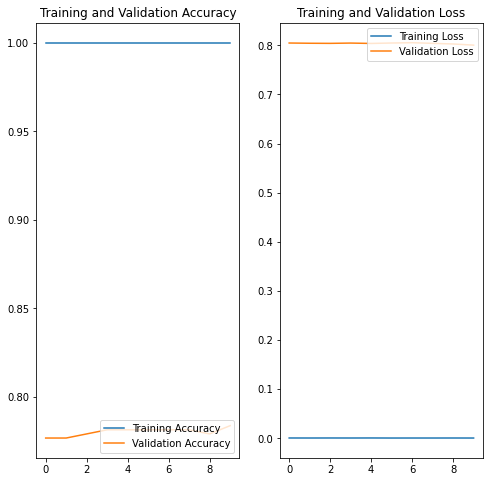

In [ ]:
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
with open("/content/drive/MyDrive/multi_checkpoint/fused_fullmodel/fused_result_3.txt", "w") as file:
    for item in acc:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in val_acc:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in loss:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in val_loss:
        file.write(str(item) + "\n")